# FACE GENARATION USING GANs
## **GOAL**:
_**Goal is to get a generator network to generate *new* images of faces that look as realistic as possible!**_



In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    
    # define transformation
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # getting data and then tranform
    data = datasets.ImageFolder(data_dir, transform=transform)
    
    # data loader
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    
    return data_loader


**CREATE DATA LOADER**



In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

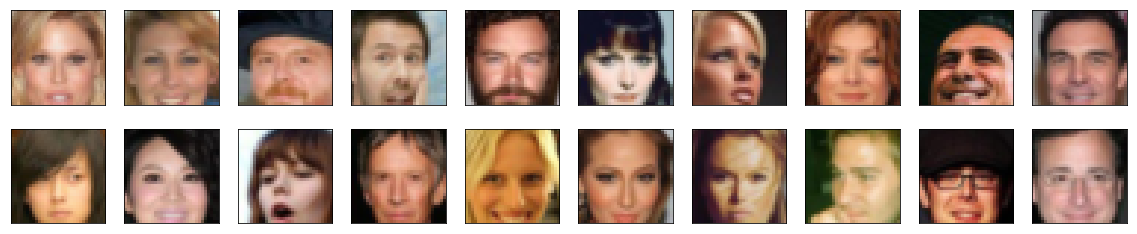

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

**Pre-process your image data and scale it to a pixel range of -1 to 1**



In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7333)
Max:  tensor(0.9529)



### **DEFINE MODEL**

_**A GAN is comprised of two adversarial networks, a discriminator and a generator.**_


**Complete the Discriminator class**
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # define convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # define fully-connected layers
        self.fc = nn.Linear(4*4*conv_dim*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten the image
        x = x.view(-1, 4*4*self.conv_dim*4)
        
        # fully-connected layer
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    
        
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # define first fully-connected layer
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        
        # define deconvolutional layers
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # define a tanh layer for the last layer
        self.tanh = nn.Tanh()
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        # upsampling
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.tanh(self.deconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


### **INIALISE THE WEIGHTS OF NETWORKS**



In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0., 0.02)
        # for bias
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0.)
    

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


**DEFINE MODEL HYPERPARAMETERS** 

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### **TRAINING**



In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!



###  **DISCRIMINATOR & GENERATOR LOSSES**

Now we need to calculate the losses for both types of adversarial networks.

**Discriminator Losses**

 * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


 **Generator Loss**

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

 **Complete real and fake loss functions**

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

### **OPTIMIZERS**



In [19]:
import torch.optim as optim
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))

---
### **TRAINING FUNCTION**



In [20]:
from workspace_utils import active_session

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    with active_session():
        for epoch in range(n_epochs):

            # batch training loop
            for batch_i, (real_images, _) in enumerate(celeba_train_loader):

                batch_size = real_images.size(0)
                real_images = scale(real_images)

                # ===============================================
                #         YOUR CODE HERE: TRAIN THE NETWORKS
                # ===============================================

                # 1. Train the discriminator on real and fake images
                d_optimizer.zero_grad()

                # compute real loss on real images
                if train_on_gpu:
                    real_images = real_images.cuda()

                D_out_real = D(real_images)
                d_real_loss = real_loss(D_out_real)

                # generate fake images
                latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                latent_z = torch.from_numpy(latent_z).float()

                if train_on_gpu:
                    latent_z = latent_z.cuda()

                fake_images = G(latent_z)

                # compute fake loss on fake images
                D_out_fake = D(fake_images)
                d_fake_loss = fake_loss(D_out_fake)

                # compute total loss at Discriminator and perform backward + opti
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                d_optimizer.step()

                # 2. Train the generator with an adversarial loss
                g_optimizer.zero_grad()

                # generate fake images
                latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                latent_z = torch.from_numpy(latent_z).float()

                if train_on_gpu:
                    latent_z = latent_z.cuda()

                fake_images = G(latent_z)

                # compute loss at Discriminator with flipped labels
                D_out = D(fake_images)
                g_loss = real_loss(D_out)    # use real_loss to flip labels

                # perform backprop and opti
                g_loss.backward()
                g_optimizer.step()


                # ===============================================
                #              END OF YOUR CODE
                # ===============================================

                # Print some loss stats
                if batch_i % print_every == 0:
                    # append discriminator loss and generator loss
                    losses.append((d_loss.item(), g_loss.item()))
                    # print discriminator and generator loss
                    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                            epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.5050 | g_loss: 0.6259
Epoch [    1/   30] | d_loss: 0.2121 | g_loss: 2.8604
Epoch [    1/   30] | d_loss: 0.1716 | g_loss: 3.0439
Epoch [    1/   30] | d_loss: 0.2624 | g_loss: 3.1671
Epoch [    1/   30] | d_loss: 0.3953 | g_loss: 2.1092
Epoch [    1/   30] | d_loss: 0.5852 | g_loss: 1.2693
Epoch [    1/   30] | d_loss: 0.5678 | g_loss: 1.4521
Epoch [    1/   30] | d_loss: 0.6979 | g_loss: 2.2766
Epoch [    1/   30] | d_loss: 0.6898 | g_loss: 1.6353
Epoch [    1/   30] | d_loss: 0.9474 | g_loss: 0.9402
Epoch [    1/   30] | d_loss: 0.9806 | g_loss: 1.6959
Epoch [    1/   30] | d_loss: 0.9773 | g_loss: 1.2476
Epoch [    1/   30] | d_loss: 1.1894 | g_loss: 0.8336
Epoch [    1/   30] | d_loss: 1.0765 | g_loss: 1.1591
Epoch [    1/   30] | d_loss: 1.1317 | g_loss: 0.7717
Epoch [    2/   30] | d_loss: 1.1927 | g_loss: 0.9110
Epoch [    2/   30] | d_loss: 1.0764 | g_loss: 0.9105
Epoch [    2/   30] | d_loss: 1.2654 | g_loss: 0.8158
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.6575 | g_loss: 1.6761
Epoch [   11/   30] | d_loss: 0.8000 | g_loss: 1.5292
Epoch [   11/   30] | d_loss: 0.9480 | g_loss: 1.4102
Epoch [   11/   30] | d_loss: 0.9012 | g_loss: 1.2749
Epoch [   11/   30] | d_loss: 0.9208 | g_loss: 1.0175
Epoch [   11/   30] | d_loss: 0.8660 | g_loss: 1.6828
Epoch [   11/   30] | d_loss: 1.1171 | g_loss: 1.3210
Epoch [   11/   30] | d_loss: 1.1456 | g_loss: 2.1452
Epoch [   11/   30] | d_loss: 1.0083 | g_loss: 1.0840
Epoch [   11/   30] | d_loss: 0.8758 | g_loss: 1.0900
Epoch [   11/   30] | d_loss: 0.8671 | g_loss: 1.1313
Epoch [   11/   30] | d_loss: 0.9706 | g_loss: 1.7976
Epoch [   11/   30] | d_loss: 1.0435 | g_loss: 0.7759
Epoch [   12/   30] | d_loss: 0.9560 | g_loss: 1.0003
Epoch [   12/   30] | d_loss: 0.7520 | g_loss: 1.0366
Epoch [   12/   30] | d_loss: 1.2175 | g_loss: 0.8887
Epoch [   12/   30] | d_loss: 0.8538 | g_loss: 1.4546
Epoch [   12/   30] | d_loss: 0.6679 | g_loss: 1.7672
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.8416 | g_loss: 1.4484
Epoch [   21/   30] | d_loss: 0.5529 | g_loss: 2.2350
Epoch [   21/   30] | d_loss: 0.8703 | g_loss: 2.8263
Epoch [   21/   30] | d_loss: 0.5738 | g_loss: 1.4398
Epoch [   21/   30] | d_loss: 0.7069 | g_loss: 1.7947
Epoch [   21/   30] | d_loss: 0.6215 | g_loss: 2.3828
Epoch [   21/   30] | d_loss: 0.6394 | g_loss: 1.4228
Epoch [   21/   30] | d_loss: 0.5738 | g_loss: 1.9992
Epoch [   21/   30] | d_loss: 0.4540 | g_loss: 1.8985
Epoch [   21/   30] | d_loss: 0.6662 | g_loss: 1.1606
Epoch [   21/   30] | d_loss: 0.6520 | g_loss: 1.8965
Epoch [   22/   30] | d_loss: 0.8645 | g_loss: 2.2887
Epoch [   22/   30] | d_loss: 0.8212 | g_loss: 0.9433
Epoch [   22/   30] | d_loss: 0.5781 | g_loss: 2.4069
Epoch [   22/   30] | d_loss: 0.4307 | g_loss: 1.9320
Epoch [   22/   30] | d_loss: 0.6980 | g_loss: 1.6472
Epoch [   22/   30] | d_loss: 0.7069 | g_loss: 1.6786
Epoch [   22/   30] | d_loss: 0.3819 | g_loss: 2.1638
Epoch [   22/   30] | d_loss

### **TRAINING LOSS**

Plot the training losses for the generator and discriminator, recorded after each epoch.

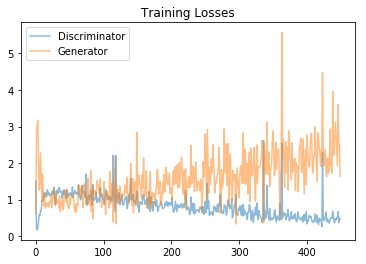

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

**GENERATOR SAMPLES FROM TRAINING**

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

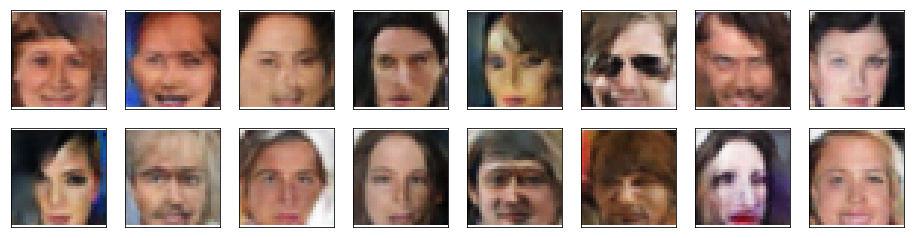

In [25]:
_ = view_samples(-1, samples)

**Answer:** I noticed that the model is generated celebrity faces that are all white. No surprise as the dataset is biased to celebrity white people. One way to improve the model is to have larger models that have the opportunity to learn more features in a data feature space. This allows the model to learn the distribution of the dataset in order to be able to generate more new types of faces. Another way to improve the model is to increase the dataset that includes black people as well. The more dataset the network trains on, the more features it will learn and generalize well. As faces are not that clear, Changing the hyperparameters, specifically, the number of epochs definitely will generate better accurate faces.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.